Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt # plot data, plt.showimg, plt.plot
import numpy as np # powerfull improved it array
import os
import sys
import tarfile # dezip zipFiles
from IPython.display import display, Image
from scipy import ndimage # create an array from an image
from sklearn.linear_model import LogisticRegression # simple linear model wx +b = Y
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

/Users/AndyMC/miniconda2/envs/tf/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

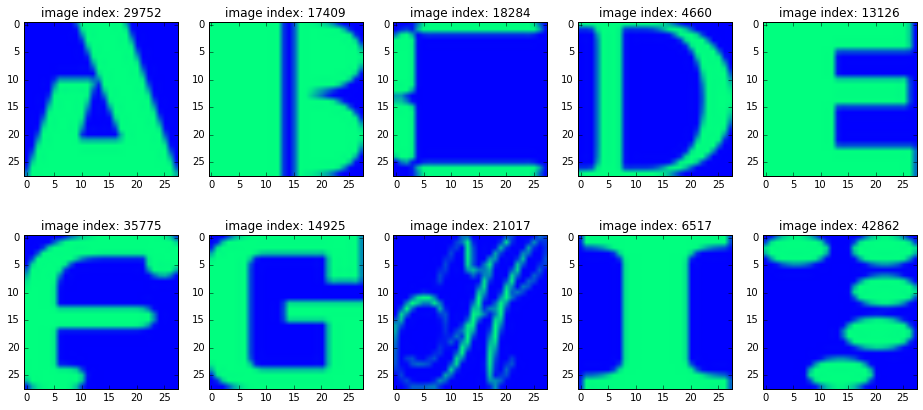

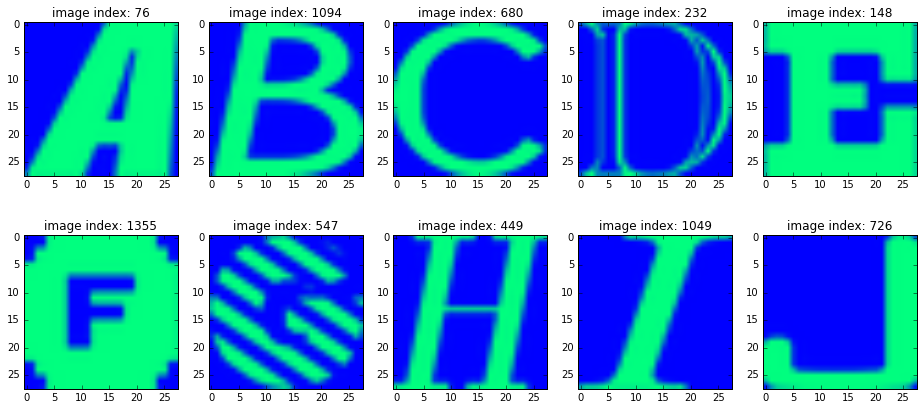

In [4]:
# image_data = (ndimage.imread(image_file).astype(float) - 
#                     pixel_depth / 2) / pixel_depth

def take_a_peek(folders):
    fig = plt.figure()
    fig.set_size_inches(16, 7)
    
    for idx, f in enumerate(folders):
        data = os.listdir(f)
        index = np.random.randint(len(data))
        image = os.path.join(f, data[index])
        img = ndimage.imread(image)
        
        a = fig.add_subplot(2, 5, idx+1)
        a.set_title('image index: %d' % index )
        
        plt.imshow(img, cmap=plt.cm.winter)
       
    plt.show()
        
take_a_peek(train_folders)
take_a_peek(test_folders)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

### Solution 1 
<p><b>by AndyMC</b></p>

<ol>
    <li>Just dePickle the first dataSet</li>
    <li>Take the first letter as a sample</li>
    <li>Plot each row in the sample ( 28 by 28 )</li>
</ol>

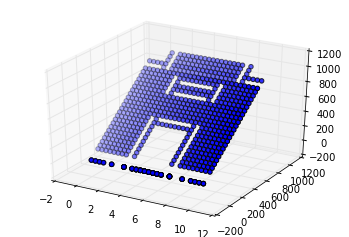

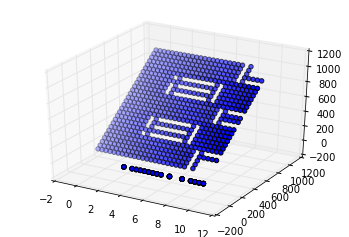

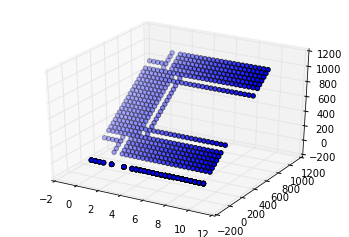

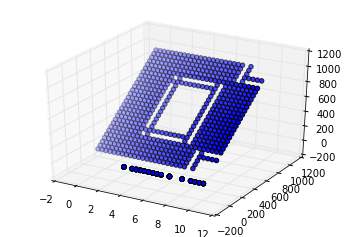

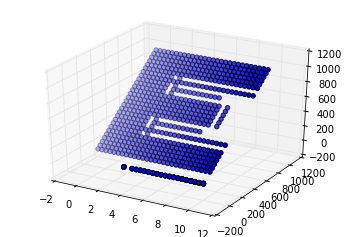

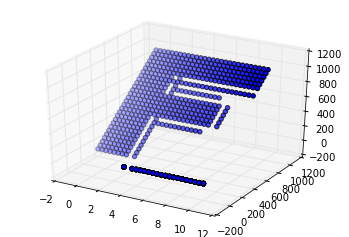

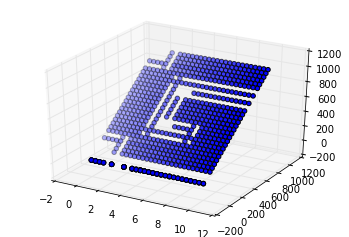

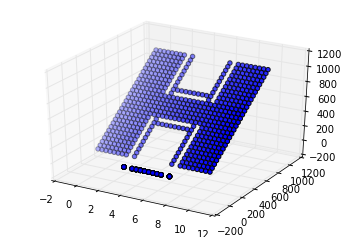

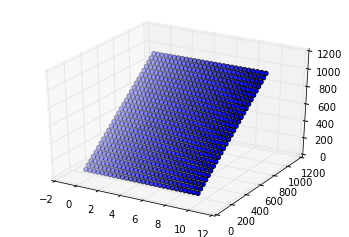

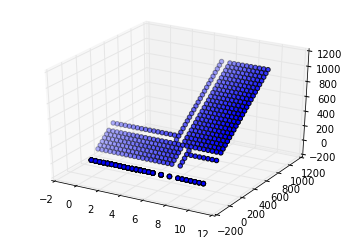

In [7]:
# train_datasets = maybe_pickle(train_folders, 45000)
# test_datasets = maybe_pickle(test_folders, 1800)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def rendarray(sample): 
    sample_render = []
    x = np.linspace(1, 10, 28)[::-1]
    for idx, row in enumerate(sample):
        r = []
        for num in row: 
            if num == -0.5:
                r.append(0)
            else:
                r.append((1 * x[idx]) * 100)
        sample_render.append(r)
    return sample_render            


def show_datasets(train_datasets):
    
    x = np.linspace(0, 10, 28)
    for idx, letter in enumerate(train_datasets):
        letters = pickle.load(open(letter, "rb"))
        sample = letters[25]
        sample_render = rendarray(sample)
#         a=fig.add_subplot(2,5,idx+1)
        fig = plt.figure()
#         fig.set_size_inches(16, 7)
        ax = fig.gca(projection='3d')
        for row in sample_render:
            # TODO Try to print a 2 x 5 graph
            ax.scatter(x, row, zs=row)    
        
show_datasets(train_datasets)    


### Solution 2 Using imshow( )
<p><b>by AndyMC</b></p>

<ol>
    <li> Use pyPlot imshow(imgArray)</li>
</ol>


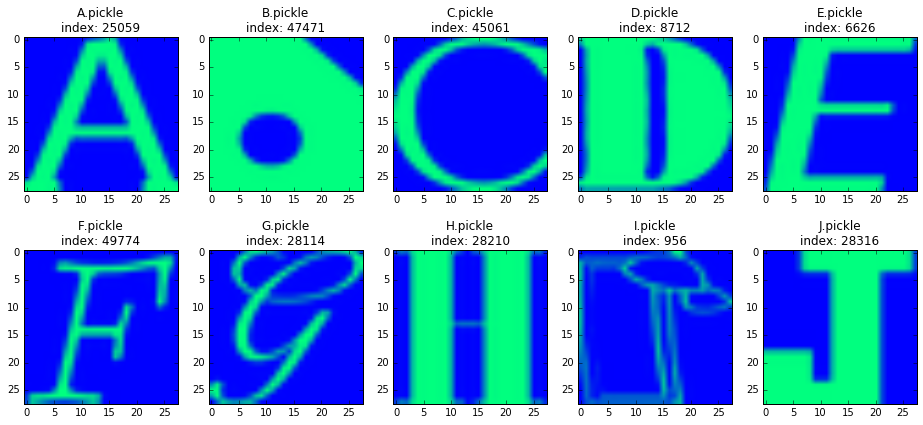

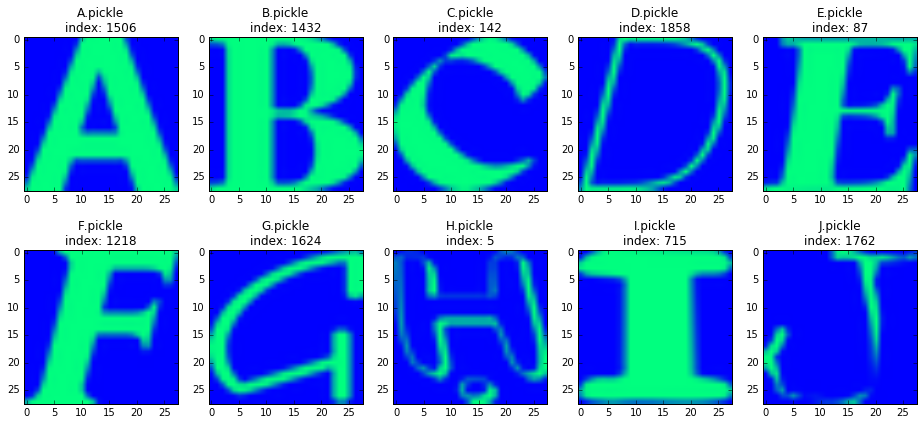

In [9]:
# train_datasets = maybe_pickle(train_folders, 45000)
# test_datasets = maybe_pickle(test_folders, 1800)
import random
%matplotlib inline

def show_sets(datasets): 
    fig = plt.figure()
    fig.set_size_inches(16, 7)
    
    for idx, letter in enumerate(datasets):
        try:
            with open(letter, "rb") as f:
                fonts = pickle.load(f)
            index = np.random.randint(len(fonts))

            label = letter.split('/')[1]
            title = '%s\nindex: %s' % (label, str(index))

            a=fig.add_subplot(2,5,idx+1)
            a.set_title(title)

            
            plt.imshow(fonts[index], cmap=plt.cm.winter)
                
        except Exception as e:
            print('Unable to process data from:', letter, '||', e)
            
    plt.show()

show_sets(train_datasets)
show_sets(test_datasets)


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [10]:
# Get all data from *.pickle files to graph later
# and dont be proccess it again and again
# train_datasets = maybe_pickle(train_folders, 45000)
# test_datasets = maybe_pickle(test_folders, 1800)

def unPickle(element):
    with open(element, 'rb') as f:
        name_ext = os.path.basename(f.name)
        name = os.path.splitext(name_ext)[0]
        data = pickle.load(f)
        return name, data
    
def get_pickle(datasets):
    sets_labels = []
    sets_data = []
    print('unPickle: ', datasets)
    for element in datasets:
        name, data = unPickle(element)
        sets_labels.append(name)
        sets_data.append(data)
    
    return sets_labels, sets_data


        
trainLabels, trainData  = get_pickle(train_datasets)
testLabels, testData  = get_pickle(test_datasets)


unPickle:  ['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
unPickle:  ['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


In [11]:
# train_datasets = maybe_pickle(train_folders, 45000)
# test_datasets = maybe_pickle(test_folders, 1800)

# trainLabels, trainData  = get_pickle(train_datasets)
# testLabels, testData  = get_pickle(test_datasets)

def count_images(labels, data):
    print ("Labels: ", labels)
    print("Data Lenght: ", len(data))
    count_images = {}
    for i, label in enumerate(labels):
        lenght = len(data[i])
        count_images[label] = lenght
        print(label, lenght)
    print('count_images: ', count_images)
    items = count_images.values()
    min_ = min(items)
    max_ = max(items)
    print('min:', min_, 'max:', max_, 'diff:', max_ - min_,'\n\n')
    return count_images


train_img_count = count_images( trainLabels, trainData )
test_img_count = count_images( testLabels, testData )

Labels:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
Data Lenght:  10
A 52909
B 52911
C 52912
D 52911
E 52912
F 52912
G 52912
H 52912
I 52912
J 52911
count_images:  {'A': 52909, 'C': 52912, 'B': 52911, 'E': 52912, 'D': 52911, 'G': 52912, 'F': 52912, 'I': 52912, 'H': 52912, 'J': 52911}
min: 52909 max: 52912 diff: 3 


Labels:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
Data Lenght:  10
A 1872
B 1873
C 1873
D 1873
E 1873
F 1872
G 1872
H 1872
I 1872
J 1872
count_images:  {'A': 1872, 'C': 1873, 'B': 1873, 'E': 1873, 'D': 1873, 'G': 1872, 'F': 1872, 'I': 1872, 'H': 1872, 'J': 1872}
min: 1872 max: 1873 diff: 1 




Labels:  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J')
Elements:  (52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911)


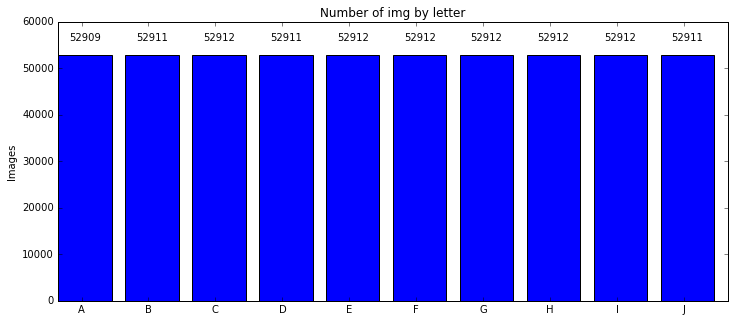

In [12]:

'''Start make graphs of all this numbers and labels'''

# trainLabels, trainData  = get_pickle(train_datasets)
# testLabels, testData  = get_pickle(test_datasets)

# train_img_count = count_images( trainLabels, trainData )
# test_img_count = count_images( testLabels, testData )

# print(train_img_count)
# print(zip(*sorted(train_img_count.items())))

labels, elements = zip(*sorted(train_img_count.items()))
print('Labels: ', labels)
print('Elements: ', elements)

ind = np.arange(len(labels)) 
# print('ind: ', ind)
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
# rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)
rects1 = ax.bar(ind, elements)

# add some text for labels, title and axes ticks
ax.set_ylabel('Images')
ax.set_title('Number of img by letter')
ax.set_xticks(ind + width)
ax.set_xticklabels(labels)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

Labels:  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J')
Elements:  [52909, 52911, 52911, 52911, 52912, 52912, 52912, 52912, 52912, 52912]


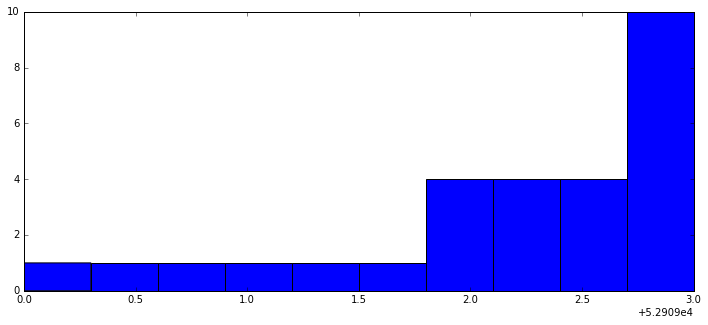

In [13]:
def show_hist(img_count):
    labels, elements = zip(*sorted(img_count.items()))
    print('Labels: ', labels)
    print('Elements: ', sorted(elements))

    ind = np.arange(len(labels)) 
    
    fig = plt.figure()
    fig.set_size_inches(12, 5)
    
    plt.hist(elements, cumulative=True)
    plt.show()
    
show_hist(train_img_count)
# show_hist(test_img_count)

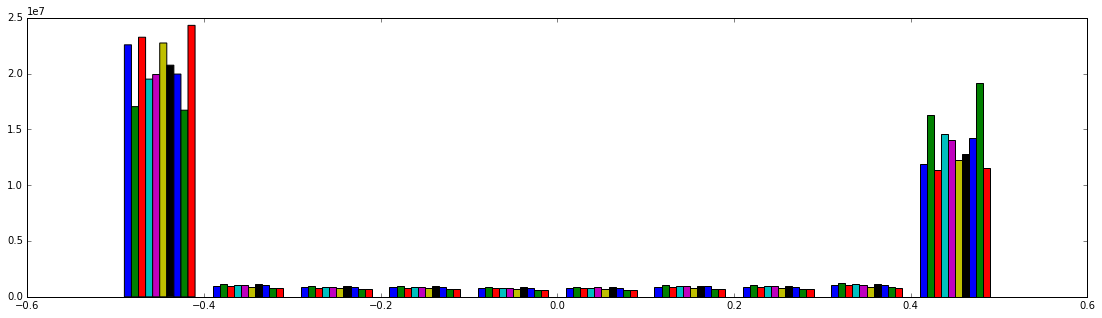

In [14]:
''' TRY #TODO A HISTOGRAM OF ALL THE DATA '''
fig = plt.figure()
fig.set_size_inches(19, 5)

plt.hist(trainData)
plt.show()

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. <b>The labels will be stored into a separate array of integers 0 through 9.</b>

Also create a validation dataset for hyperparameter tuning.

In [15]:
print('train_datasets:\n', train_datasets)
print('\ntest_datasets:\n', test_datasets)

train_datasets:
 ['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']

test_datasets:
 ['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


In [16]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets( train_datasets, train_size, valid_size)

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size) 

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [17]:
# train_dataset, train_labels = randomize(train_dataset, train_labels)
# test_dataset, test_labels = randomize(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

def check1_b(dataset, labels):
    print('dataset.shape: ', dataset.shape)
    print('labels.shape: ', labels.shape)
    print('mean(dataset): ', np.mean(dataset))
    print('std(dataset): ', np.std(dataset))
    print('\n')
    return np.mean(dataset), np.std(dataset)

train_mean_b, train_std_b = check1_b(train_dataset, train_labels)
valid_mean_b, valid_std_b = check1_b(valid_dataset, valid_labels)
test_mean_b, test_std_b = check1_b(test_dataset, test_labels)

dataset.shape:  (200000, 28, 28)
labels.shape:  (200000,)
mean(dataset):  -0.0815841
std(dataset):  0.454247


dataset.shape:  (10000, 28, 28)
labels.shape:  (10000,)
mean(dataset):  -0.0814181
std(dataset):  0.454205


dataset.shape:  (10000, 28, 28)
labels.shape:  (10000,)
mean(dataset):  -0.0741095
std(dataset):  0.458794




Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [18]:
perm = np.random.permutation(4)
print(perm) # random indeces generator
t = np.array(['a','b','c','d','e','f','g','h'])
print(t[perm]) # this tricks work for nparray

[1 3 0 2]
['b' 'd' 'a' 'c']


In [19]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [20]:
# train_dataset, train_labels = randomize(train_dataset, train_labels)
# test_dataset, test_labels = randomize(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

def check1(dataset, labels):
    print('dataset.shape: ', dataset.shape)
    print('labels.shape: ', labels.shape)
    print('mean(dataset): ', np.mean(dataset))
    print('std(dataset): ', np.std(dataset))
    print('\n')
    return np.mean(dataset), np.std(dataset)



train_mean_a, train_std_a = check1(train_dataset, train_labels)
valid_mean_a, valid_std_a = check1(valid_dataset, valid_labels)
test_mean_a, test_std_a = check1(test_dataset, test_labels)

print(train_mean_a, train_std_a)
print(train_mean_b, train_std_b) 
print()
print(valid_mean_a, valid_std_a)
print(valid_mean_b, valid_std_b)
print()
print(test_mean_a, test_std_a)
print(test_mean_b, test_std_b)

dataset.shape:  (200000, 28, 28)
labels.shape:  (200000,)
mean(dataset):  -0.0815842
std(dataset):  0.454247


dataset.shape:  (10000, 28, 28)
labels.shape:  (10000,)
mean(dataset):  -0.0814179
std(dataset):  0.454205


dataset.shape:  (10000, 28, 28)
labels.shape:  (10000,)
mean(dataset):  -0.0741095
std(dataset):  0.458794


-0.0815842 0.454247
-0.0815841 0.454247

-0.0814179 0.454205
-0.0814181 0.454205

-0.0741095 0.458794
-0.0741095 0.458794


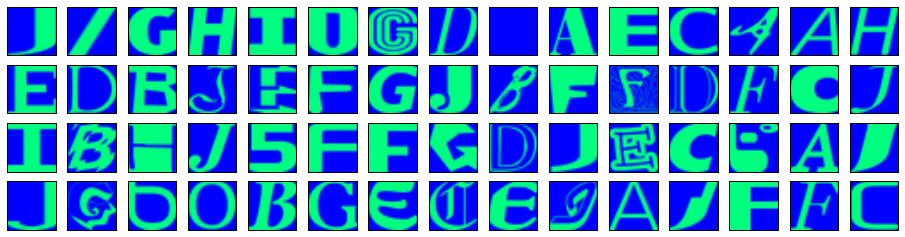

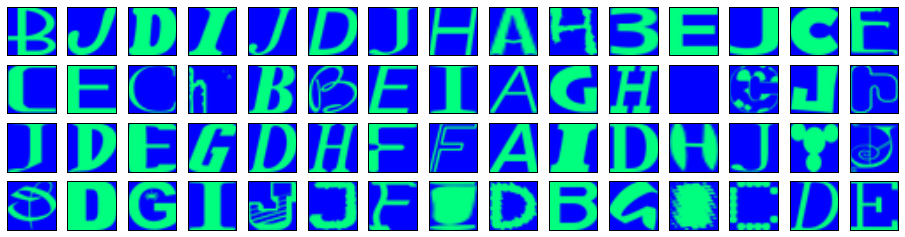

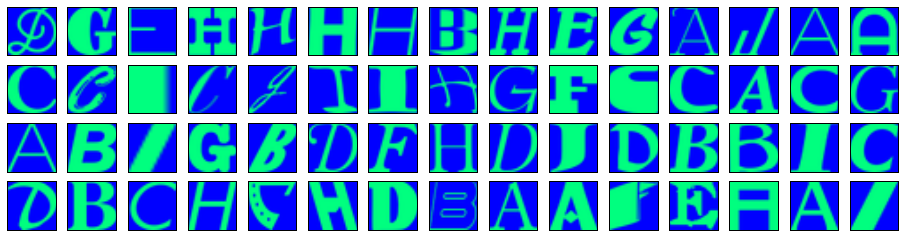

In [21]:
def show_ds(dataset):
    fig = plt.figure()
    fig.set_size_inches(16, 4)
    idx = 1
    for img in dataset[:60,:,:]:
        a = fig.add_subplot(4, 15, idx)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        plt.imshow(img, cmap=plt.cm.winter)
        idx += 1
    plt.show()    

def check2(dataset, labels):
    show_ds(dataset)

check2(train_dataset, train_labels)
check2(valid_dataset, valid_labels)
check2(test_dataset, test_labels)

In [22]:
'''Have any other idea how to verify the shuffle data !!'''
def foo(dataset):
    pass

def check3(dataset, labels):
    print(dataset.shape)
    print(labels.shape)
    foo(dataset)

check3(train_dataset, train_labels)
# check3(valid_dataset, valid_labels)
# check3(test_dataset, test_labels)

(200000, 28, 28)
(200000,)


Finally, let's save the data for later reuse:

In [23]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [24]:
statinfo = os.stat(pickle_file)
size = statinfo.st_size / 1000000.0
print('Compressed pickle size: %.2f MB' % size)
# Compressed pickle size: 690.80 MB

Compressed pickle size: 690.80 MB


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [25]:
with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    
print(dataset.keys())

['train_labels', 'valid_labels', 'test_labels', 'test_dataset', 'train_dataset', 'valid_dataset']


In [26]:
train_dataset = dataset["train_dataset"]
train_labels = dataset["train_labels"]
valid_dataset = dataset["valid_dataset"]
valid_labels = dataset["valid_labels"]
test_dataset = dataset["test_dataset"]
test_labels = dataset["test_labels"]

print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(200000, 28, 28)
(200000,)
(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


In [27]:
from hashlib import md5

def unique_elements(dataset):
    total = dataset.shape[0]
    unique = len(set([md5(img).digest() for img in dataset]))
    repeated = total - unique
    print('Number of elements:')
    print('Total: %d' % total)
    print('Unique: %d' % unique)
    print('Repeated: %d percentage: %.2f%%' % (repeated, (repeated/float(total))*100))
    print()
       
unique_elements(train_dataset)
unique_elements(valid_dataset)  
unique_elements(test_dataset)  

Number of elements:
Total: 200000
Unique: 187354
Repeated: 12646 percentage: 6.32%

Number of elements:
Total: 10000
Unique: 9865
Repeated: 135 percentage: 1.35%

Number of elements:
Total: 10000
Unique: 9783
Repeated: 217 percentage: 2.17%



In [29]:
from hashlib import md5

def repeatedIn(sub_ds, main_ds):
    sub_ds_unique = set([md5(img).digest() for img in sub_ds])
    main_ds_unique = set([md5(img).digest() for img in main_ds])
    only_in_sub = sub_ds_unique - main_ds_unique
    
    sub = len(sub_ds_unique)
    main = len(main_ds_unique)
    only = len(only_in_sub)
    overlaps = sub - only 
    
    print('Elements in sub_dataset: %d' % sub)
    print('Elements in main_dataset: %d' % main)
    print('Elements in sub withOut main dataset: %d' % only)
    print('Overlaps in sub from main: %d percentage %.2f' % (overlaps, (overlaps/float(sub)*100)))
    print()

repeatedIn(valid_dataset, train_dataset)
repeatedIn(test_dataset, train_dataset)  


Elements in sub_dataset: 9865
Elements in main_dataset: 187354
Elements in sub withOut main dataset: 8913
Overlaps in sub from main: 952 percentage 9.65

Elements in sub_dataset: 9783
Elements in main_dataset: 187354
Elements in sub withOut main dataset: 8629
Overlaps in sub from main: 1154 percentage 11.80



In [30]:
'''All unique elements in hashes !!'''
train_hashes = set([md5(image).digest() for image in train_dataset])
valid_hashes = set([md5(image).digest() for image in valid_dataset])
test_hashes = set([md5(image).digest() for image in test_dataset])

In [31]:
def hash_Img(dataset):
    return {md5(img).digest():idx for idx, img in enumerate(dataset)}

train_hash_img = hash_Img(train_dataset) 
valid_hash_img = hash_Img(valid_dataset)  
test_hash_img = hash_Img(test_dataset) 

print(len(train_hash_img), type(train_hash_img))
print(len(valid_hash_img), type(valid_hash_img))
print(len(test_hash_img), type(test_hash_img))
# 187441 <type 'dict'>
# 9858 <type 'dict'>
# 9804 <type 'dict'>

187354 <type 'dict'>
9865 <type 'dict'>
9783 <type 'dict'>


In [32]:
# to slow to print in jupyter with out been a np.array
# clean_train_dataset = train_hash_img.values()
clean_train_idx = train_hash_img.values()

ctrain_dataset, ctrain_labels = train_dataset[clean_train_idx], train_labels[clean_train_idx]

print('ctrain_dataset.shape: ', ctrain_dataset.shape)
print('ctrain_labels.shape: ', ctrain_labels.shape)
print(len(set([md5(img).digest() for img in ctrain_dataset])))

ctrain_dataset.shape:  (187354, 28, 28)
ctrain_labels.shape:  (187354,)
187354


In [33]:
def clean_overlap(sub, sublabels, main):
    sub_hash_img = hash_Img(sub)
    
    sub_hashes = set([md5(img).digest() for img in sub])
    main_hashes = set([md5(img).digest() for img in main])
    clean_sub = sub_hashes - main_hashes
    
    clean_dataset_idx = []
    for hash_ in clean_sub:
        clean_dataset_idx.append(sub_hash_img[hash_])
    
    return sub[clean_dataset_idx], sublabels[clean_dataset_idx]
    
cvalid_dataset, cvalid_labels = clean_overlap(valid_dataset, valid_labels, train_dataset)
ctest_dataset, ctest_labels = clean_overlap(test_dataset, test_labels, train_dataset)

print(ctrain_dataset.shape)
print(ctrain_labels.shape)
print(cvalid_dataset.shape)
print(cvalid_labels.shape)
print(ctest_dataset.shape)
print(ctest_labels.shape)

(187354, 28, 28)
(187354,)
(8913, 28, 28)
(8913,)
(8629, 28, 28)
(8629,)


In [34]:
# train_dataset, train_labels = randomize(train_dataset, train_labels)
# test_dataset, test_labels = randomize(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

def check1(dataset, labels):
    print('dataset.shape: ', dataset.shape)
    print('labels.shape: ', labels.shape)
    print('mean(dataset): ', np.mean(dataset))
    print('std(dataset): ', np.std(dataset))
    print('\n')
    return np.mean(dataset), np.std(dataset)



train_mean_a, train_std_a = check1(ctrain_dataset, ctrain_labels)
valid_mean_a, valid_std_a = check1(cvalid_dataset, cvalid_labels)
test_mean_a, test_std_a = check1(ctest_dataset, ctest_labels)

dataset.shape:  (187354, 28, 28)
labels.shape:  (187354,)
mean(dataset):  -0.0888003
std(dataset):  0.452173


dataset.shape:  (8913, 28, 28)
labels.shape:  (8913,)
mean(dataset):  -0.089735
std(dataset):  0.45157


dataset.shape:  (8629, 28, 28)
labels.shape:  (8629,)
mean(dataset):  -0.0836971
std(dataset):  0.456207




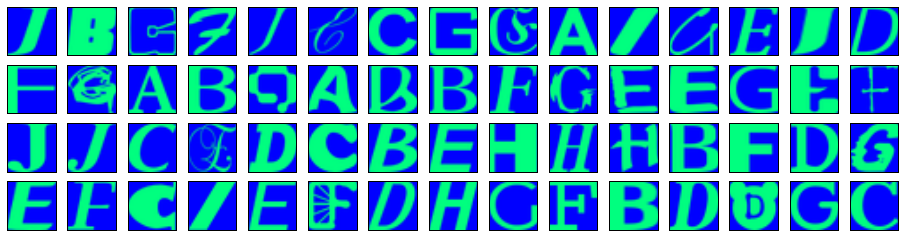

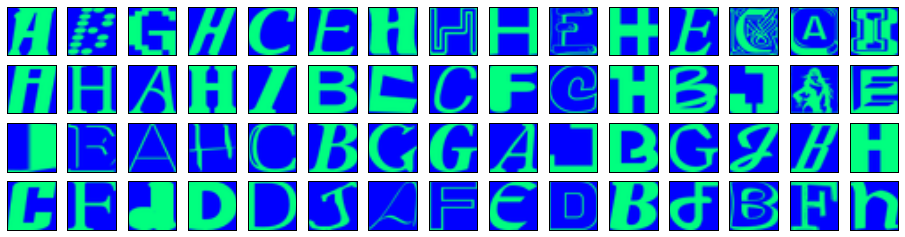

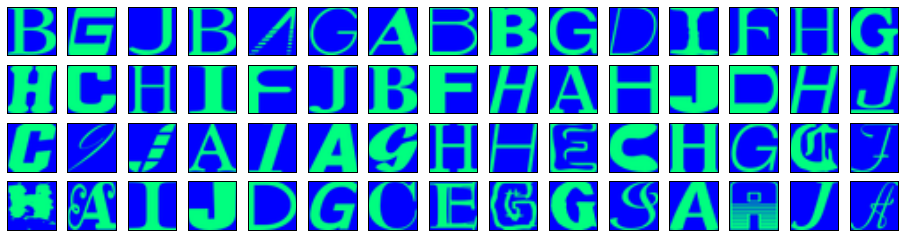

In [35]:
check2(ctrain_dataset, ctrain_labels)
check2(cvalid_dataset, cvalid_labels)
check2(ctest_dataset, ctest_labels)

In [36]:
pickle_file = 'clean_notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'ctrain_dataset': ctrain_dataset,
    'ctrain_labels':  ctrain_labels,
    'cvalid_dataset': cvalid_dataset,
    'cvalid_labels':  cvalid_labels,
    'ctest_dataset':  ctest_dataset,
    'ctest_labels':   ctest_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [38]:
statinfo = os.stat(pickle_file)
size = statinfo.st_size / 1000000.0
print('Compressed pickle size: %.2f MB' % size)
# Compressed pickle size: 643.60 MB

Compressed pickle size: 643.37 MB


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [39]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    
print(dataset.keys())

['train_labels', 'valid_labels', 'test_labels', 'test_dataset', 'train_dataset', 'valid_dataset']


In [40]:
train_dataset = dataset["train_dataset"]
train_labels = dataset["train_labels"]
valid_dataset = dataset["valid_dataset"]
valid_labels = dataset["valid_labels"]
test_dataset = dataset["test_dataset"]
test_labels = dataset["test_labels"]

print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(200000, 28, 28)
(200000,)
(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


In [41]:
# data using 50, 100, 1000 and 5000
ds_50 = train_dataset[:50].reshape(50, 28*28)
ds_50_labels = train_labels[:50]
ds_100 = train_dataset[:100].reshape(100, 28*28)
ds_100_labels = train_labels[:100]
ds_1000 = train_dataset[:1000].reshape(1000, 28*28)
ds_1000_labels = train_labels[:1000]
ds_5000 = train_dataset[:5000].reshape(5000, 28*28)
ds_5000_labels = train_labels[:5000]
ds_all = train_dataset.reshape(train_dataset.shape[0], 28*28)
ds_all_labels = train_labels

print(ds_50.shape)
print(ds_50_labels.shape)
print(ds_100.shape)
print(ds_100_labels.shape)
print(ds_1000.shape)
print(ds_1000_labels.shape)
print(ds_5000.shape)
print(ds_5000_labels.shape)
print(ds_all.shape)
print(ds_all_labels.shape)

(50, 784)
(50,)
(100, 784)
(100,)
(1000, 784)
(1000,)
(5000, 784)
(5000,)
(200000, 784)
(200000,)


In [42]:
# from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
# multi_class='multinomial'
logistic = LogisticRegression()
logistic_all = LogisticRegression()
print(logistic,'\n')
print(dir(logistic))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

['C', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', '_predict_proba_lr', 'class_weight', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'fit_transform', 'get_params', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'transform', 'verbose', 'warm_start']


In [43]:
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

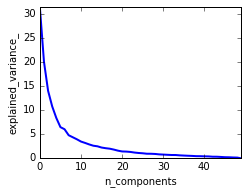

In [44]:
'''For 50'''
X_digits = ds_50
pca.fit(X_digits)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

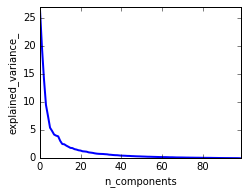

In [45]:
'''For 100'''
X_digits = ds_100
pca.fit(X_digits)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

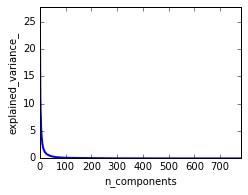

In [46]:
'''For 1000'''
X_digits = ds_1000
pca.fit(X_digits)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

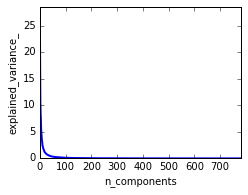

In [47]:
'''For 5000'''
X_digits = ds_5000
pca.fit(X_digits)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

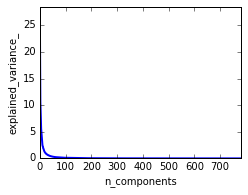

In [48]:
'''For ALL'''
X_digits = ds_all
pca.fit(X_digits)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [49]:
# multi_class='multinomial'
# supported only by the ‘lbfgs’ and ‘newton-cg’ solvers
logistic = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logistic_all = LogisticRegression(multi_class='multinomial', solver='newton-cg')
print(logistic,'\n')
print(dir(logistic))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False) 

['C', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', '_predict_proba_lr', 'class_weight', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'fit_transform', 'get_params', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'transform', 'verbose', 'warm_start']


In [50]:
%time print('hello world!!')

hello world!!
CPU times: user 104 µs, sys: 38 µs, total: 142 µs
Wall time: 121 µs


In [51]:
print(type(ds_50), ds_50.shape)
print(type(ds_50_labels), ds_50_labels.shape)

%time logistic.fit(ds_50, ds_50_labels)

<type 'numpy.ndarray'> (50, 784)
<type 'numpy.ndarray'> (50,)
CPU times: user 130 ms, sys: 13.4 ms, total: 144 ms
Wall time: 163 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
print(type(ds_all), ds_all.shape)
print(type(ds_all_labels), ds_all_labels.shape)

%time logistic_all.fit(ds_all, ds_all_labels)

<type 'numpy.ndarray'> (200000, 784)
<type 'numpy.ndarray'> (200000,)
CPU times: user 57min 16s, sys: 3min 5s, total: 1h 22s
Wall time: 22min 45s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

(50, 10) <type 'numpy.ndarray'>
(50, 10) <type 'numpy.ndarray'>
(50,)

[ 1.02994074  5.24563807 -1.23383411 -2.4460626  -1.07826325  0.13377351
 -2.74824376 -1.13340917  0.75483268  1.4756279 ]
[ 0.29609054  2.10511164 -1.6596605  -0.21351133  0.28212647 -0.14453555
 -3.52620456  0.72441742  0.42216849  1.71399737]



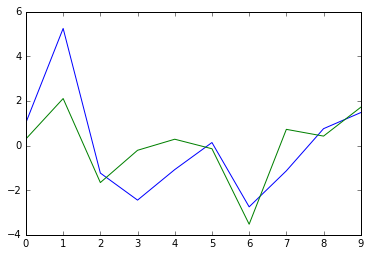

In [55]:
confidence_scores = logistic.decision_function(ds_50)
confidence_scores_all = logistic_all.decision_function(ds_50)

print(confidence_scores.shape, type(confidence_scores))
print(confidence_scores_all.shape, type(confidence_scores_all))
print(ds_50_labels.shape)
print()
print(confidence_scores[23])
print(confidence_scores_all[23])
print()
plt.plot(confidence_scores[23])
plt.plot(confidence_scores_all[23])

# plt.plot(confidence_scores[:10])

In [56]:
print(logistic.get_params())

{'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'multinomial', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'newton-cg', 'class_weight': None}


In [58]:
# print(test_dataset[0])
# valid_dataset = valid_dataset.reshape(valid_dataset.shape[0], 28*28)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 28*28)

print('predition:   ', logistic.predict(test_dataset[:10]))
print('data_labels: ', test_labels[:10])

print('predition:   ', logistic_all.predict(test_dataset[:10]))
print('data_labels: ', test_labels[:10])

predition:    [9 6 3 1 7 7 5 1 7 1]
data_labels:  [3 6 4 7 7 7 7 1 7 4]
predition:    [9 6 4 7 7 7 7 1 7 4]
data_labels:  [3 6 4 7 7 7 7 1 7 4]


In [59]:
# print(test_dataset[0])
# valid_dataset = valid_dataset.reshape(valid_dataset.shape[0], 28*28)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 28*28)

predict_50 = logistic.predict(test_dataset[10:20])
predict_all = logistic_all.predict(test_dataset[10:20])
labels = test_labels[10:20]                                   
                                   
print('predition:   ', predict_50)
print('data_labels: ', labels)
error = np.equal(predict_50, labels)
percent_correct = sum(error) / float(len(labels))
print('corects predictions: ', percent_correct, '\n')                              

print('predition:   ', predict_all)
print('data_labels: ', labels)
error2 = np.equal(predict_all, labels)
percent_correct2 = sum(error2) / float(len(labels) )
print('corects predictions: ', percent_correct2)

predition:    [9 0 9 0 9 2 9 8 5 0]
data_labels:  [6 0 9 0 0 2 2 8 2 9]
corects predictions:  0.5 

predition:    [6 0 9 0 0 2 2 8 2 5]
data_labels:  [6 0 9 0 0 2 2 8 2 9]
corects predictions:  0.9



predition:    [4]
predition:    [4]


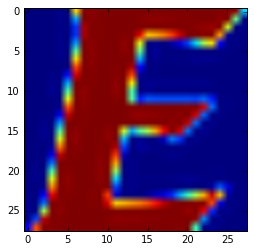

In [94]:
pixel_depth = 255
test = (ndimage.imread('test.png').astype(float) - pixel_depth / 2) / pixel_depth
plt.imshow(test)
img_test = test.reshape(1, 28*28)

print()

predict_50 = logistic.predict(img_test)
predict_all = logistic_all.predict(img_test)
                                   
print('predition:   ', predict_50)
print('predition:   ', predict_all)


In [97]:
print(test_labels.shape)

(10000,)


In [98]:
# regr.score(X_test, y_test)

score_50 = logistic.score(test_dataset, test_labels)
score_all = logistic_all.score(test_dataset, test_labels)
                                   
print('score_50:   ', score_50)
print('score_all:   ', score_all)


score_50:    0.6497
score_all:    0.9008


In [100]:
from sklearn import metrics

print("Logistic regression using raw pixel features:\n%s\n" % (
      metrics.classification_report(test_labels, logistic.predict(test_dataset))))

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.84      0.68      0.75      1000
          1       0.77      0.65      0.70      1000
          2       0.88      0.61      0.72      1000
          3       0.56      0.75      0.65      1000
          4       0.92      0.38      0.54      1000
          5       0.56      0.92      0.70      1000
          6       0.69      0.38      0.49      1000
          7       0.79      0.51      0.62      1000
          8       0.79      0.70      0.74      1000
          9       0.42      0.92      0.57      1000

avg / total       0.72      0.65      0.65     10000




In [101]:
from sklearn import metrics

print("Logistic regression using raw pixel features:\n%s\n" % (
      metrics.classification_report(test_labels, logistic_all.predict(test_dataset))))

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.92      0.91      0.92      1000
          1       0.91      0.89      0.90      1000
          2       0.89      0.94      0.92      1000
          3       0.90      0.92      0.91      1000
          4       0.92      0.87      0.89      1000
          5       0.90      0.93      0.92      1000
          6       0.91      0.90      0.90      1000
          7       0.91      0.90      0.90      1000
          8       0.86      0.85      0.86      1000
          9       0.88      0.91      0.90      1000

avg / total       0.90      0.90      0.90     10000




In [170]:
folder = 'notMNIST_small/C/'

img_file = random.choice(os.listdir(folder))
img_path = folder+img_file

display(Image(img_path))

In [171]:
print(img_path)

notMNIST_small/C/R29sZGVuVHlwZVNDRUYtT3JpZ2luYWwub3Rm.png


In [172]:
from scipy import ndimage # create an array from an image
pixel_depth = 255.0
# test = (ndimage.imread('test.png').astype(float) - pixel_depth / 2) / pixel_depth
print((ndimage.imread(img_path).astype(float)[0]))
print((ndimage.imread(img_path).astype(float) - (pixel_depth))[0])
print((ndimage.imread(img_path).astype(float) - (pixel_depth/2))[0])

norm_img = (ndimage.imread(img_path).astype(float) - (pixel_depth/2)) / pixel_depth
print(norm_img[0])

[   0.    0.    0.    0.    0.    0.    3.    1.    0.    0.   28.   81.
  135.  183.  206.  222.  240.  247.  250.  253.  255.  255.  255.  253.
  255.  217.   12.    0.]
[-255. -255. -255. -255. -255. -255. -252. -254. -255. -255. -227. -174.
 -120.  -72.  -49.  -33.  -15.   -8.   -5.   -2.    0.    0.    0.   -2.
    0.  -38. -243. -255.]
[-127.5 -127.5 -127.5 -127.5 -127.5 -127.5 -124.5 -126.5 -127.5 -127.5
  -99.5  -46.5    7.5   55.5   78.5   94.5  112.5  119.5  122.5  125.5
  127.5  127.5  127.5  125.5  127.5   89.5 -115.5 -127.5]
[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.48823529 -0.49607843 -0.5        -0.5        -0.39019608 -0.18235294
  0.02941176  0.21764706  0.30784314  0.37058824  0.44117647  0.46862745
  0.48039216  0.49215686  0.5         0.5         0.5         0.49215686
  0.5         0.35098039 -0.45294118 -0.5       ]


<IPython.core.display.Image object>

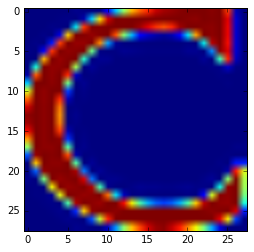

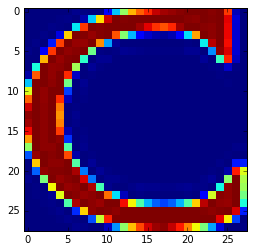

In [178]:
display(Image(norm_img))
plt.imshow(norm_img)
plt.show()
plt.imshow(norm_img, interpolation='nearest')
plt.show()

In [174]:
# reshape to one row of 28*28 = 784 elements
img_reshape = norm_img.reshape(1, 28*28)
print(img_reshape.shape)

(1, 784)


In [175]:
# simple linear model wx +b = Y
# >> from sklearn.linear_model import LogisticRegression

# multi_class='multinomial'
# supported only by the ‘lbfgs’ and ‘newton-cg’ solvers
# >> logistic = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# >> logistic_all = LogisticRegression(multi_class='multinomial', solver='newton-cg')

predict_50 = logistic.predict(img_reshape)
predict_all = logistic_all.predict(img_reshape)
                                   
print('prediction:   ', predict_50)
print('prediction:   ', predict_all)

prediction:    [2]
prediction:    [2]


In [180]:
# t = pickle.load(open("notMNIST.pickle", "r"))
# del(t) # this should free up more memory spaces

In [218]:
print(test_dataset[:10])

[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
 [ 0.40980393  0.5         0.49607843 ...,  0.49607843  0.5        -0.11568628]
 ..., 
 [-0.1509804  -0.43333334 -0.46470588 ..., -0.49607843 -0.5        -0.49607843]
 [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]


In [212]:
print(np.array([[1,2],[3,4]]))
print(np.array([[1,2],[3,4]]).ravel())


[[1 2]
 [3 4]]
[1 2 3 4]


In [216]:
print(np.array([[1,2],[3,4]]).ravel() == np.array([[1,6],[7,8]]).ravel())
print((np.array([[1,2],[3,4]]).ravel() == np.array([[1,6],[7,8]]).ravel())*100)
print(np.mean((np.array([[1,2],[3,4]]).ravel() == np.array([[1,6],[7,8]]).ravel()))*100)


[ True False False False]
[100   0   0   0]
25.0


In [217]:
predict_50 = logistic.predict(test_dataset)

classif_rate = np.mean(predict_50.ravel() == test_labels.ravel()) * 100
print(test_labels[:10])
print(predict_50[:10])
print("classif_rate for predict_50: %f " % (classif_rate))

[3 6 4 7 7 7 7 1 7 4]
[9 6 3 1 7 7 5 1 7 1]
classif_rate for predict_50: 64.970000 


In [225]:
print(ctrain_dataset.shape)
print(ctrain_labels.shape)
lenght = ctrain_dataset.shape[0]
width = ctrain_dataset.shape[1]
height = ctrain_dataset.shape[2]

X = ctrain_dataset.reshape(lenght, width*height)
print(X.shape)

(187354, 28, 28)
(187354,)
(187354, 784)


In [221]:
logistic_all_clean = LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [226]:
%time logistic_all_clean.fit(X, ctrain_labels)

CPU times: user 51min 35s, sys: 2min 30s, total: 54min 5s
Wall time: 18min 16s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [229]:
predict_all = logistic_all.predict(test_dataset)

classif_rate = np.mean(predict_all.ravel() == test_labels.ravel()) * 100
print(test_labels[:10])
print(predict_all[:10])
print("classif_rate for predict_50: %f " % (classif_rate))

[3 6 4 7 7 7 7 1 7 4]
[9 6 4 7 7 7 7 1 7 4]
classif_rate for predict_50: 90.080000 


In [230]:
x_test = ctest_dataset.reshape(ctest_dataset.shape[0],28*28)
predict_all_clean = logistic_all_clean.predict(x_test)

classif_rate = np.mean(predict_all_clean.ravel() == ctest_labels.ravel()) * 100
print(ctest_labels[:10])
print(predict_all_clean[:10])
print("classif_rate for predict_all_clean: %f " % (classif_rate))

[1 6 9 1 0 6 0 1 1 6]
[1 4 9 1 7 6 0 1 1 6]
classif_rate for predict_all_clean: 89.268745 
